# **Model Testing** - Minus 112th Congress

**All Features:**

Data columns (total 29 columns):

Specific Identifiers:

- BillID      51067 non-null object


How far it made it:

- PassH       51067 non-null int64
- PassS       51067 non-null int64
- PLawDate    1393 non-null object - MAKE BOOL?
- PLawNum     51067 non-null object
- PLaw        51067 non-null int64
- Veto        51067 non-null int64

Bill Descriptive Info:

- BillType    51067 non-null object
- Title       51067 non-null object
- Cong        51067 non-null int64
- Summary     51017 non-null object - REMOVE NULL
- ImpBill     51067 non-null int64
- Chamber     51067 non-null int64 (H or S)

Info about Rep Bill Proposer:

- Cosponsr    51067 non-null float64
- IntrDate    51025 non-null object - REMOVE NULL
- Mult        51067 non-null int64
- Class       51067 non-null float64
- District    51067 non-null float64
- FrstConH    51067 non-null float64
- FrstConS    51067 non-null float64
- Gender      51067 non-null int64
- MRef        51067 non-null int64
- NameFull    51067 non-null object
- Party       51067 non-null float64
- Postal      51067 non-null object
- Majority    51067 non-null int64

Other general bill info:

- Major       51067 non-null float64
- Minor       51067 non-null float64

The URL:

- URL         51067 non-null object


List of the models to test and the parameters to tune:
  
**Models:**
- Naive Bayes
- Logistic Regression
- Random Forest
- SVM

**Evaluations:**
- Accuracy, precision, recall, f1
- Confusion Matrix
- ROC/AUC

**Class Imbalance Issues:**
- Run a model on just one topic with good class distribution:
- Undersampling
- Use top 10 words for each PassH as features


- try running models with only words
- ADD top five pass, top five not pass


- try one without 112th
    

# **Query Data**

In [159]:
pip install -U sentence-transformers

     |████████████████████████████████| 51kB 5.7MB/s eta 0:00:011
     |████████████████████████████████| 450kB 11.0MB/s eta 0:00:01
     |████████████████████████████████| 81.1MB 29.4MB/s eta 0:00:01��█ | 78.8MB 29.4MB/s eta 0:00:01████████▌| 79.9MB 29.4MB/s eta 0:00:01
     |████████████████████████████████| 870kB 35.2MB/s eta 0:00:01
     |████████████████████████████████| 686kB 15.1MB/s eta 0:00:01
     |████████████████████████████████| 1.1MB 9.6MB/s eta 0:00:01
     |████████████████████████████████| 133kB 32.8MB/s eta 0:00:01
     |████████████████████████████████| 71kB 15.7MB/s eta 0:00:01
     |████████████████████████████████| 5.9MB 10.3MB/s eta 0:00:01
  Stored in directory: /Users/melissamunz/Library/Caches/pip/wheels/b4/ce/39/5bbda8ac34eb52df8c6531382ca077773fbfcbfb6386e5d66c
  Stored in directory: /Users/melissamunz/Library/Caches/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
  Stored in directory: /Users/melissamunz/Library/Caches/pip/wheels/1c/7

In [1]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db

import config_final as config
from schema import DbSchema



In [2]:
bills_db = DbSchema(config)

# topics_db = bills_db.query('SELECT * from topics')

In [3]:
# Full dataframe for running models

# df = bills_db.query("""
#     SELECT cb.BillID, 
#         cb.BillType, 
#         cb.Chamber, 
#         cb.Cong, 
#         cb.Cosponsr, 
#         cb.Title,
#         cb.IntrDate,
#         cb.Mult,
#         cb.PLaw,
#         cb.Veto,
#         cb.District,
#         cb.FrstConH,
#         cb.FrstConS,
#         cb.Gender,
#         cb.NameFull,
#         cb.Party,
#         cb.Postal,
#         cb.PassH,
#         cb.PassS,
#         cb.PLawDate,
#         cb.Majority,
#         tp.dominant_topic         
#     FROM 
#         con_bills.current_bills as cb
#     JOIN
#         con_bills.topics as tp
#     ON cb.BillID = tp.BillID
#     WHERE cb.Cong >= 110""")


In [4]:
#Get a query of all topics counts by PassH
#Run model on just that one topic that is most evenly distributed

df = bills_db.query("""
    SELECT
        cb.Title,
        cb.PassH
    FROM con_bills.current_bills as cb
    JOIN con_bills.topics as tp
    ON cb.BillID = tp.BillID
    WHERE cb.Cong >=110
    """)
df.head()

,Title,PassH
0,To provide for the implementation of the recom...,1
1,Reserved for Speaker.,0
2,To amend the Higher Education Act of 1965 to p...,0
3,To award a congressional gold medal to Edward ...,0
4,To amend the Haitian Hemispheric Opportunity t...,0


In [5]:
# df.groupby(['dominant_topic', 'PassH']).size()

In [6]:
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

# **Final Data Cleaning**

Add:
- Len title words or anything?
- tfidf on title?

REMOVE:
- PLawNum (not necessary for analysis)
- Major/Minor (no keys)
- PLawDate (too few)
- ImpBill (almost all are)


Edit: 
- BillType: 
- Chamber: To binary
- Cong: OHE
- Postal: OHE

How to deal with: Things that happen after House passage!?

In [7]:
df.shape

(51067, 2)

In [8]:
df.isnull().sum()

Title    0
PassH    0
dtype: int64

In [9]:
#Replace Nulls in IntrDate - Figure out how to do this!
#Maybe change to just month or just year
# df['IntrDate'].head()

# **Tokenizer:**

In [10]:
#import tokenizer

import spacy
from spacy.lang.en import English
import en_core_web_sm
import string
import re

nlp = English()

stop_words = spacy.lang.en.stop_words.STOP_WORDS

nlp.Defaults.stop_words |= {"bill","amend", "purpose", "united", "state", "states", "secretary", "act", "federal", "provide"}

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')

stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [11]:
def tokenizer(text):
    
    #lowercase everything
    lower_text = text.lower()
    
    #remove punctuation
#     no_pun_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    
    #get rid of weird characters
    text = replace_with_space.sub('',lower_text)
    
    #remove numbers
    just_words_text = just_words.sub('', text)
    
    #add spacy tokenizer
    mytokens = nlp(just_words_text, disable=['parser', 'ner'])
#     print(mytokens)
    
    #for POS tagging
#     mytokens = [word for word in mytokens if (word.pos_ == 'NOUN') or (word.pos_ == 'VERB') or (word.pos_ == 'ADJ') or (word.pos_ == 'ADV')]
    
    #lemmatize
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    #MAP SPECIFIC WORDS to others (veteran from veterans)

    #add stopwords
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return mytokens
    

# **Train and Test**

In [12]:
from sklearn.model_selection import train_test_split

X = df['Title']
y = df['PassH']


In [13]:
X.head()


0    To provide for the implementation of the recom...
1                                Reserved for Speaker.
2    To amend the Higher Education Act of 1965 to p...
3    To award a congressional gold medal to Edward ...
4    To amend the Haitian Hemispheric Opportunity t...
Name: Title, dtype: object

**One hot encoding**

All categorical variables:
- 

In [14]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

Then One-Hot-Encode:

- Encode categorical integer features using a one-hot aka one-of-K scheme.
- The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features.
- The output will be a sparse matrix where each column corresponds to one possible value of one feature.
- It is assumed that input features take on values in the range [0, n_values).
- This encoding is needed for feeding categorical data to many scikit-learn estimators, notably linear models and SVMs with the standard kernels.

# **Modeling**

Import packages:

- CountVectorizer
- TFIDF

- Naive Bayes
- Logistic Regression
- Random Forest

**Remember to look at feature importances!

In [15]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import FeatureHasher

# We will train our classifier with the following features:

# We create the preprocessing pipelines for all data types.


**Train test split**

In [16]:
#Train Test split!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=1)

In [17]:
X_test.shape

(10214,)

In [18]:
X_train.shape

(40853,)

In [19]:
y_train.shape

(40853,)

In [25]:
# tok_X_train = tokenizer(X_train)

**Sentence Embeddings**

In [20]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:30<00:00, 13.3MB/s] 


In [26]:
# sentence_embeddings_train = model.encode(X_train)
# sentence_embeddings_test = model.encode(X_test)

**Naive Bayes**

In [131]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer


nb = Pipeline([('vect', CountVectorizer(tokenizer=tokenizer, max_features=None)),
               ('clf', MultinomialNB()),
              ])

parameters = None

nb.fit(X_train, y_train)

nb_y_pred = nb.predict(X_test)

print(confusion_matrix(y_test, nb_y_pred))
print(classification_report(y_test, nb_y_pred))

nb_confusion_matrix = (confusion_matrix(y_test, nb_y_pred))

[[8780  608]
 [ 577  249]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      9388
           1       0.29      0.30      0.30       826

    accuracy                           0.88     10214
   macro avg       0.61      0.62      0.62     10214
weighted avg       0.89      0.88      0.88     10214



Text(0.5, 1, 'Confusion Matrix')

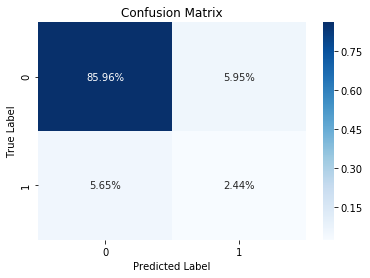

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(nb_confusion_matrix/np.sum(nb_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

Use Pipeline or DFMapper!

**Logistic Regression**

- Precision means the percentage of your results which are relevant. 
- recall refers to the percentage of total relevant results correctly classified by your algorithm.

Also make a precision recall curve

In [152]:
from sklearn.linear_model import LogisticRegression

# Bring in OHE?

lr_clf = Pipeline([('vect', CountVectorizer(tokenizer=tokenizer, max_df=0.5, max_features=None)),
               ('clf', LogisticRegression(class_weight='balanced', C=.8)),
              ])

# Logistic Regression Classifier
# lr_classifier = LogisticRegression()

lr_clf.fit(X_train, y_train)

lr_y_pred = lr_clf.predict(X_test)

print(confusion_matrix(y_test, lr_y_pred))
print(classification_report(y_test, lr_y_pred))

lr_confusion_matrix = confusion_matrix(y_test, lr_y_pred)

/Users/melissamunz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[7654 1734]
 [ 349  477]]
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      9388
           1       0.22      0.58      0.31       826

    accuracy                           0.80     10214
   macro avg       0.59      0.70      0.60     10214
weighted avg       0.90      0.80      0.83     10214



Text(0.5, 1, 'Confusion Matrix')

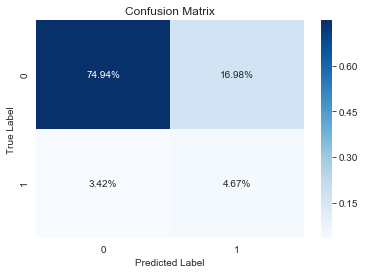

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(lr_confusion_matrix/np.sum(lr_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [154]:
#for ROC/AUC Curve

lr_dec = lr_clf.decision_function(X_test)

import numpy as np
from sklearn.metrics import roc_auc_score
lr_roc_auc = roc_auc_score(y_test, lr_y_pred)
lr_roc_auc

#This is a decent ROC Score. Remember lays between .5 and 1

0.6963889814517734

Test AUC: 0.7688534691136281


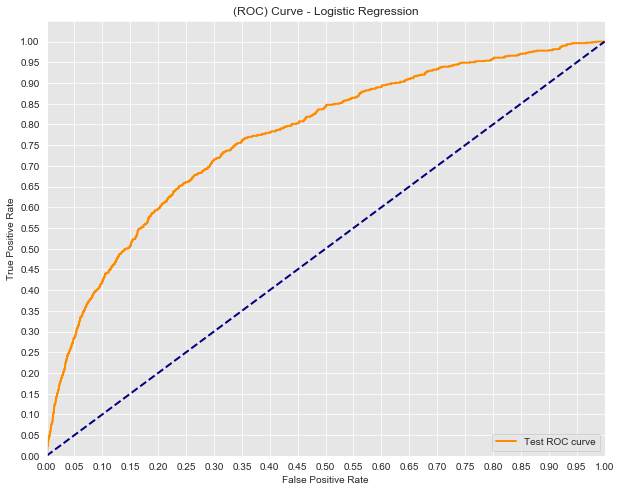

In [155]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, lr_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

In [156]:
from sklearn.metrics import average_precision_score

lr_average_precision = average_precision_score(y_test, lr_dec)

print('Average precision-recall score: {0:0.2f}'.format(
      lr_average_precision))

Average precision-recall score: 0.26


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.26')

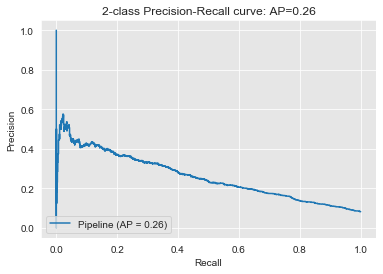

In [157]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lr_clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(lr_average_precision))

Evaluate:
- ROC/AUC

**Random Forest**

Class Imbalance: To overcome this issue, we used repeated random sub-sampling. Initially, we construct the testing data and the NoS training data sub-samples. For each disease, we train NoS classifiers and test all of them on the same data set. The final labels of the testing data are computed using a majority voting scheme.

In [43]:
from sklearn.ensemble import RandomForestClassifier

#add bag of trees?
#add OHE

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=None, max_features='auto', n_estimators=10, class_weight="balanced"))])


rf_pipeline.fit(X_train, y_train) 

rf_y_pred = rf_pipeline.predict(X_test)

print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))

rf_confusion_matrix = confusion_matrix(y_test, rf_y_pred)

[[7324  112]
 [ 502  189]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7436
           1       0.63      0.27      0.38       691

    accuracy                           0.92      8127
   macro avg       0.78      0.63      0.67      8127
weighted avg       0.91      0.92      0.91      8127



Text(0.5, 1, 'Confusion Matrix')

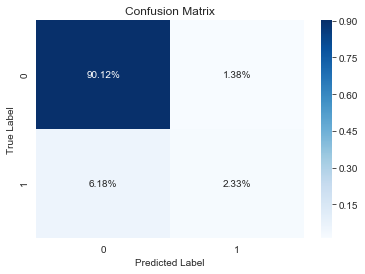

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(rf_confusion_matrix/np.sum(rf_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [45]:
feature_names = rf_pipeline.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

In [47]:
importances = rf_pipeline.steps[1][1].feature_importances_
len(importances)

1044

In [48]:
indices = np.argsort(importances)[::-1]
top_k = 10
new_indices = indices[:top_k]

In [49]:
new_indices

array([  1,   0,  65,  71,  64, 126, 125, 127, 128,  58])

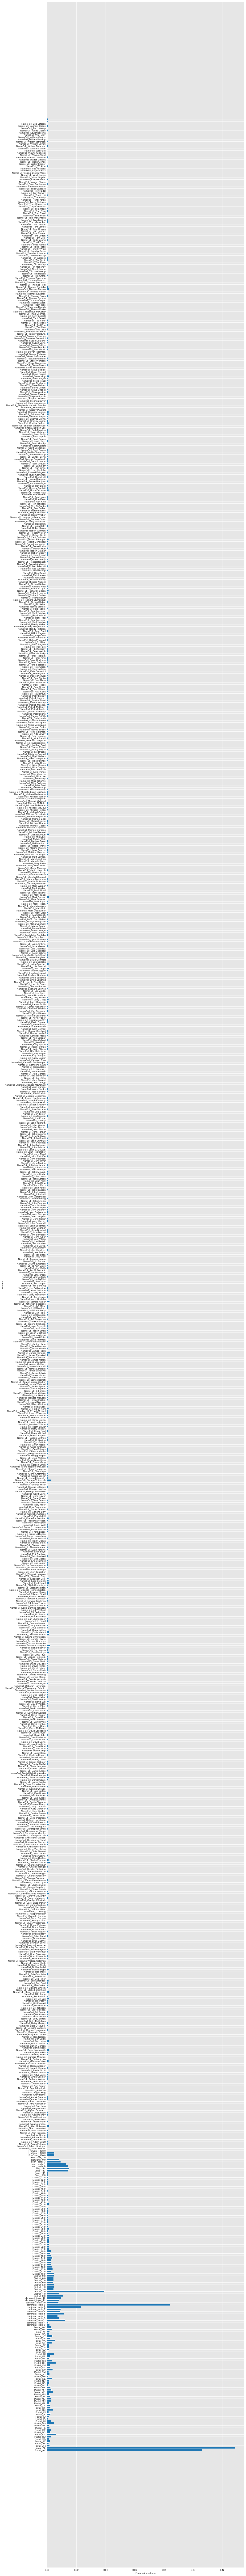

In [50]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    
#     n_features = importances.shape
    
    plt.figure(figsize=(15,200))
    plt.barh(range(1044), importances, align='center') 
    
    plt.yticks(np.arange(1044), feature_names) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rf_pipeline)

**Further review of Features**

In [ ]:

vectorizer.get_feature_names()

**FINAL MODEL**

**Further Evaluation**:
- Classification Report
- Confusion Matrix
- ROC/AUC

https://www.kaggle.com/selener/multi-class-text-classification-tfidf

In [ ]:
# Pretty Confusion Matrix - need to change for each model

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

# Comparing all Models:

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:

mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc